In [2]:
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

#%matplotlib ipympl

import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.axes._axes import Axes

from IPython.display import Audio
# Audio(data=signal.T,rate=fe)
from scipy.io import wavfile
from scipy.signal import stft,istft

<font color="red" size=6><b>Meta paramètres</b></font>

Comme calculer les spectrogrammes prend du temps, nous pouvons les calculer une fois pour toute puis les sauvegarder sur le disque. Toutefois, <font color="red"><b>ceci triple l'espace occupé sur disque</b></font>: passant de 6.3 Go à 17.2 Go. Veuillez donc préciser le paramètre `SAVE_SPECTROGRAMS` selon si vous pouvez utiliser cet espace.

In [3]:
DIRECTORY = Path("source_separation")
SAVE_SPECTROGRAMS = True

# Chargement des signaux, Visualisation et Dataset

## Chargement des signaux et spectrogrammes

In [4]:
train_folder = DIRECTORY / "train"
train_small_folder = DIRECTORY / "train_small"
test_folder = DIRECTORY / "test"
get_path = lambda folder,i : folder / ("000"+str(i))[-4:]

datasets_sizes = {
    train_small_folder : 50,
    train_folder : 5000,
    test_folder : 2000
}

Tous les signaux ont la même fréquence d'échantillonage, même longueur; et donc les mêmes f et t échantillonés pour le Spectrogramme.

In [5]:
def check_all_same(folder=train_small_folder):
    f_ref = None
    t_ref = None
    for i in range(datasets_sizes[train_small_folder]):
        fe,signal = wavfile.read(get_path(train_small_folder,i) / "voice.wav")
        len_signal = len(signal)
        f_spec,t_spec,spec = stft(
            signal,fs=fe,
            nperseg=400,nfft=512,noverlap=100)
        if f_ref is None: f_ref = f_spec ; t_ref = t_spec
        assert np.allclose(f_spec,f_ref)
        assert np.allclose(t_spec,t_ref)
    return fe,f_ref,t_ref

fe,f_ref,t_ref = check_all_same()
get_spectrogram = lambda signal : stft(signal,fs=fe,nperseg=400,nfft=512,noverlap=100)[2]

In [6]:
def load_signal_folder(folder: Path,
        load_signals=True,
        load_spectrograms=True) -> dict[str,dict]:
    """
    Return a dictionary with 3 sub dicts: "voice", "noise" and "mix"; and an "SNR" key.
    Each sub dict has 3 keys: "filename", "signal" and "spectrogram" 
    (except if load_signals or load_spectrograms are set to False)
    """
    keys = ["voice","noise","mix"]
    res = dict((k,dict()) for k in keys)
    for f in folder.iterdir():
        assert f.is_file()
        if "voice" in f.name: key = "voice"
        elif "noise" in f.name: key = "noise"
        else: 
            key = "mix"
            if f.suffix == ".wav":
                res["SNR"] = f.name.removesuffix(".wav").split("_")[-1]
        if f.suffix == ".wav" and load_signals:
            fe,signal = wavfile.read(f)
            res[key]["filename"] = f.name
            res[key]["signal"] = signal
        elif f.suffix == ".pt" and SAVE_SPECTROGRAMS and load_spectrograms: 
            # when SAVE_SPECTROGRAMS is False, we shouldn't be able to load them 
            # to save time, otherwise it's cheating.
            res[key]["spectrogram"] = torch.load(f,weights_only=True)
    # Create missing spectrograms
    if load_spectrograms:
        for key in keys:
            if "spectrogram" not in res[key]:
                assert load_signals
                spec = get_spectrogram(res[key]["signal"])
                res[key]["spectrogram"] = spec
                if SAVE_SPECTROGRAMS:
                    torch.save(torch.tensor(spec),folder / f"{key}_spectrogram.pt")
    return res


def remove_all_spectrograms():
    for folder in [train_folder,train_small_folder,test_folder]:
        for i in range(datasets_sizes[folder]):
            folder_i: Path = get_path(folder,i)
            for f in folder_i.iterdir():
                if "spectrogram" in f.name:
                    f.unlink()

Comme calculer les spectrogrammes prend du temps, nous pouvons les calculer une fois pour toute, en sauvegardant tous les spectrogrammes sur disque. Attention, <font color="red"><b>ceci triple l'espace occupé sur disque</b></font>: passant de 6.3 Go à 17.2 Go.
Pour les retirer utiliser: `remove_all_spectrograms()`.

In [7]:
def create_spectrograms(folder: Path):
    if SAVE_SPECTROGRAMS and not (folder/"0000"/"voice_spectrogram.pt").exists():
        for i in range(datasets_sizes[folder]):
            load_signal_folder(get_path(folder,i))

create_spectrograms(train_small_folder)
create_spectrograms(test_folder)
create_spectrograms(train_folder)

In [8]:
def compute_time(folder):
    time_load_signal = 0
    time_load_spec = 0
    time_spec = 0
    start = time.perf_counter()
    for i in range(datasets_sizes[folder]):
        fe,signal = wavfile.read(get_path(folder,i) / "voice.wav")
        time_load_signal += time.perf_counter() - start ; start = time.perf_counter()
        path_spec: Path = get_path(folder,i) / "voice_spectrogram.pt"
        if path_spec.exists():
            _ = torch.load(path_spec,weights_only=True)
        time_load_spec += time.perf_counter() - start ; start = time.perf_counter()
        _ = get_spectrogram(signal)
        time_spec += time.perf_counter() - start ; start = time.perf_counter()

    print(f"Temps total pour load {datasets_sizes[folder]} signaux: {time_load_signal}")
    print(f"Temps total pour en calculer les spectrogrammes: {time_spec}")
    print(f"Comparé au temps pour charger les spectrogrammes: {time_load_spec}")

print("Première fois:")
compute_time(test_folder)
print("\nDeuxième fois:")
compute_time(test_folder)

Première fois:
Temps total pour load 2000 signaux: 0.41766995936632156
Temps total pour en calculer les spectrogrammes: 5.205843295902014
Comparé au temps pour charger les spectrogrammes: 1.5030243769288063

Deuxième fois:
Temps total pour load 2000 signaux: 0.40889594703912735
Temps total pour en calculer les spectrogrammes: 4.997139077633619
Comparé au temps pour charger les spectrogrammes: 1.4145908392965794


On voit que charger les spectrogrammes pré-calculés est plus rapide que de les calculer à chaque fois. On note aussi une grosse différence entre la première fois qu'un fichier est chargé et la seconde, j'imagine que le système place les derniers fichiers chargés dans le cache (recharger le notebook n'y change rien, donc la différence n'apparait que la toute première fois)

## Visualization

<font color="green">Note: les versions très récentes de `ipympl` ont une erreur de frappe dans le code, avec une variable nommé "buttons" au lieu de "button". Ainsi, si vous avez une version instable de `ipympl`, il se peut que d'un coup la cellule interactive ci-dessous écrivent des dizaines d'erreurs à la chaine. Nous n'avons pas trouvé ce qui les déclenche, mais vous pouvez les ignorer (puisqu'elles n'empechent pas la cellule de tourner), sinon vous pouvez simplement ouvrir le fichier d'où vient l'erreur (en cliquant sur la ligne d'erreur qui s'affiche des dizaines de fois), et changé "buttons", par "button".</font>

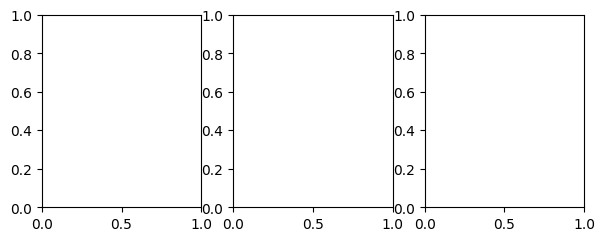

interactive(children=(IntSlider(value=1, description='i', max=49), Output()), _dom_classes=('widget-interact',…

In [9]:
def visualize_signal(folder):
    signals = load_signal_folder(folder)
    colorbars = []
    for ax,name in zip(axs,["voice","noise","mix"]):
        spec_dB = 10*np.log10(abs(signals[name]["spectrogram"].numpy()))
        plt_obj = ax.pcolormesh(
            t_ref,f_ref,spec_dB,
            vmax=np.percentile(spec_dB,99),
            vmin=np.percentile(spec_dB,10))
        colorbars.append(plt.colorbar(plt_obj,ax=ax))
        ax.set_title(signals[name]["filename"])
        ax.tick_params(axis='both', which='major', labelsize=4)
        colorbars[-1].ax.tick_params(axis='both', which='major', labelsize=4)
        ax.set_xlabel("Temps (ms)",fontsize=4)
        ax.set_ylabel("Fréquence (GHz)",fontsize=4)
    return colorbars


folder = train_small_folder
plt.close("viz")
fig_viz = plt.figure("viz",figsize=(7,2.5))
gs = gridspec.GridSpec(2,3) # to get good control of the color bars
ax_slices = [np.s_[:,i] for i in range(3)]
axs = [fig_viz.add_subplot(gs[sli]) for sli in ax_slices]
colorbars = []

@widgets.interact(i=(0,datasets_sizes[folder]-1,1))
def update(i=1):
    for ax in axs: ax.cla()
    global colorbars
    fig_viz = plt.figure("viz")
    plt.title("")
    try: 
        if colorbars != []:
            for colorbar in colorbars:
                fig_viz.delaxes(colorbar.ax)
            gs = gridspec.GridSpec(2,3)
            for ax,sli in zip(axs,ax_slices):
                ax.set_position(gs[sli].get_position(fig_viz))
                ax.set_subplotspec(gs[sli])
    except:
        print('got an error')
        pass
    folder_i = get_path(folder,i)
    colorbars = visualize_signal(folder_i)
    fig_viz.suptitle(f"Spectogrammes pour {Path(folder_i.parent.name)/folder_i.name}")
    fig_viz.tight_layout()
    plt.show()
    


## Dataset

In [10]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,
            folder: Path,
            load_signals=True,
            load_spectrograms=False):
        self.folder = folder
        self.load_signals = load_signals
        self.load_spectrograms = load_spectrograms
            
    def __len__(self):
        return datasets_sizes[self.folder]
    
    def __getitem__(self,i):
        d = load_signal_folder(
            get_path(self.folder,i),
            load_signals=self.load_signals,
            load_spectrograms=self.load_spectrograms)
        ret = []
        for name in ["voice","noise","mix"]:
            if self.load_signals:
                ret.append(d[name]["signal"])
            if self.load_spectrograms:
                ret.append(d[name]["spectrogram"])
        ret.append(d["SNR"])
        return ret

Le Dataset peut contenir les signaux et/ou les spectrogrammes. De sorte à ne charger que le nécessaire. Exemple si on veut tout charger:

In [11]:
train_dataset = MyDataset(train_folder,load_signals=True,load_spectrograms=True)
train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)
print("Dataset length:",len(train_dataset))
for voice_signal,voice_spec,noise_signal,noise_spec,mix_signal,mix_spec,snr in train_dataloader:
    print("Signal's shape: ",voice_signal.shape)
    print("Spectrogram's shape: ",voice_spec.shape)
    print("SNRs :",snr)
    break

Dataset length: 5000
Signal's shape:  torch.Size([32, 80000])
Spectrogram's shape:  torch.Size([32, 257, 268])
SNRs : ('4', '-1', '-2', '4', '-3', '4', '-2', '1', '-1', '2', '4', '-2', '2', '2', '-3', '3', '0', '0', '-1', '0', '-3', '2', '4', '1', '4', '0', '4', '-4', '3', '-3', '-4', '0')


# Seq2Seq using a U-Net: Singing Voice Separation With Deep U-Net Convolutional Networks

In [12]:
train_dataset = MyDataset(
    train_folder,
    load_signals=False,
    load_spectrograms=True)
train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)

In [13]:
for voice_spec,noise_spec,mix_spec,snr in train_dataloader:
    print("Spec's shape:",voice_spec.shape)
    print("SNRs:",snr)
    break

Spec's shape: torch.Size([32, 257, 268])
SNRs: ('1', '1', '-2', '0', '-2', '1', '-2', '2', '4', '2', '0', '2', '0', '-2', '-4', '-2', '0', '-3', '3', '3', '-1', '0', '-4', '0', '-3', '0', '-3', '2', '-2', '2', '-1', '0')
